# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Импортируем необходимые для работы библиотеки и инструменты:

In [2]:
# библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# инструменты
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import time

# блокиратор предупреждений
import warnings
warnings.filterwarnings("ignore")

Загрузим данные и ознакомимся с ними:

In [3]:
data = pd.read_csv('/datasets/autos.csv')
display(data.sample(5))
print()
data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
289094,2016-03-19 17:06:21,4999,sedan,2005,manual,116,1er,150000,12,petrol,bmw,no,2016-03-19 00:00:00,0,65549,2016-03-26 12:46:22
151315,2016-03-09 17:57:04,4699,wagon,2014,manual,95,other,150000,3,gasoline,fiat,no,2016-03-09 00:00:00,0,95632,2016-03-30 19:17:10
328441,2016-03-23 14:51:29,6700,sedan,2003,manual,170,a4,125000,10,petrol,audi,no,2016-03-23 00:00:00,0,34119,2016-04-05 18:17:11
251731,2016-03-26 18:51:16,14444,wagon,2009,auto,170,c_klasse,150000,11,gasoline,mercedes_benz,no,2016-03-26 00:00:00,0,83026,2016-04-06 08:17:24
167268,2016-03-08 19:57:17,2500,convertible,2001,manual,0,c_reihe,150000,4,petrol,volvo,NaN,2016-03-08 00:00:00,0,4103,2016-03-09 04:16:40



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object

Для построения модели прогнозирующей стоимость авто (целевой признак **Price**) избавимся на начальном этапе от признаков, которые не оказывают влияние на формирование цены, а именно:
- DateCrawled — дата скачивания анкеты из базы
- RegistrationMonth — месяц регистрации автомобиля (для определения возраста авто достаточно иметь данные о годе регистрации)
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

In [4]:
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


### Предобработка данных

#### Обработка пропущенных значений

Посмотрим на пропуски в категориальных признаках, можно ли с ними что-то сделать:

In [5]:
for column in ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']:
    print('Уникальные значения', column)
    print(data[column].value_counts(dropna=False))
    print()

Уникальные значения VehicleType
sedan          91457
small          79831
wagon          65166
NaN            37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

Уникальные значения Gearbox
manual    268251
auto       66285
NaN        19833
Name: Gearbox, dtype: int64

Уникальные значения Model
golf                  29232
other                 24421
3er                   19761
NaN                   19705
polo                  13066
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 251, dtype: int64

Уникальные значения FuelType
petrol      216352
gasoline     98720
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

Уникальные значения NotRepaired
no     247161
NaN    

- **VehicleType**: пропущенных значений NaN достаточно много 37490, при этом присутствует небольшое кроличество объявлений с типом кузова other (3288). Посмотрим на несколько таких объявлений:

In [6]:
data[data['VehicleType'] == 'other'].sample(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
201471,1850,other,1998,manual,101,3er,150000,petrol,bmw,NaN
53776,199,other,1983,NaN,77,other,100000,petrol,ford,NaN
322091,9900,other,2007,manual,110,sprinter,150000,gasoline,mercedes_benz,NaN
81319,4786,other,1969,manual,55,other,100000,petrol,audi,no
338859,2000,other,1996,manual,90,civic,150000,petrol,honda,NaN
149776,2500,other,1999,auto,0,sprinter,125000,gasoline,mercedes_benz,NaN
181332,4300,other,2004,manual,116,alhambra,150000,gasoline,seat,NaN
131611,3790,other,2004,manual,109,a_klasse,150000,gasoline,mercedes_benz,no
93446,1790,other,2001,manual,60,2_reihe,125000,petrol,peugeot,NaN
217868,700,other,1997,manual,90,civic,150000,petrol,honda,yes


Можно заметить, что значение "other" в столбце **"VehicleType"** встречается в объявлениях, где кузов авто можно достоверно указать по марке и модели, так и в объявлениях, где в графе **"Model"** указано "other" либо NaN. Соответственно можно объединить эти два значения, т.е. вместо NaN в графе **"VehicleType"** указать "other".

Аналогичным образом можно поступить и с заполнением пропусков в столбцах **"Model"** и **"FuelType"**- NaN заменить на "other".

- **Gearbox**:  в типе коробки передач есть лишь два значения manual и auto, причем авто с механической КПП значительно больше, но достоверно заменить пропуски на один из типов нельзя, поэтому вместо пропусков в данных укажем заглушку "other".

- **NotRepaired**: здесь также достоверно заменить пропуски нельзя, также укажем заглушку "other". 

*Таким образом во всех категориальных признаках пропущенные значения заменим на заглушку **"other"** дабы не искажать данные.*

In [7]:
for column in ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']:
    data[column] = data[column].fillna('other')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       354369 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           354369 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             354369 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          354369 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       354369 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Далее перейдем к обработке столбцов с количественными признаками, явных пропусков в них нет, посмотрим на наличие аномальных значений: 

In [8]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


- **Price**: минимальное значение 0 (бесплатно за авто), максимальное - 20000 Евро. Если верхняя граница вполне реалистична, то с нижней необходимо разобраться - действительно ли кто-то отдавал свой авто бесплатно либо это пропущеннные значения. Построим гистограмму распределения стоимости авто:

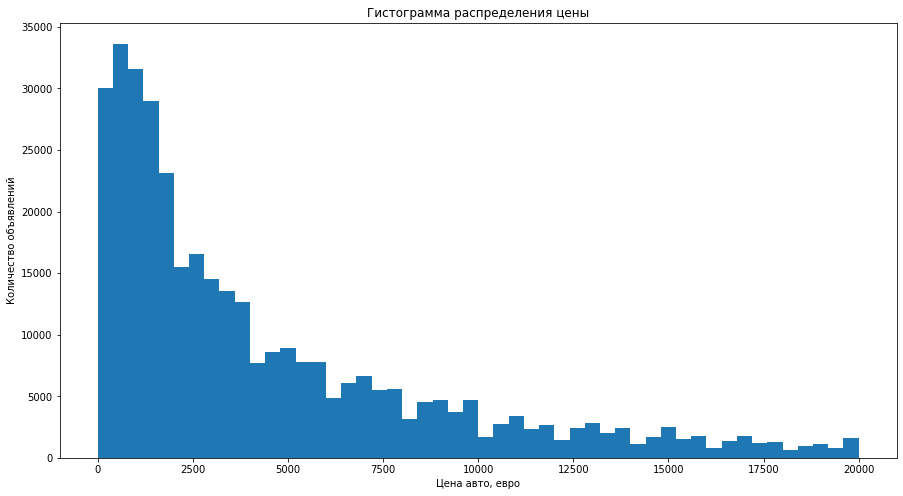

In [9]:
plt.figure(figsize=(15, 8))
plt.hist(data['Price'], bins = 50)
plt.title("Гистограмма распределения цены")
plt.xlabel("Цена авто, евро")
plt.ylabel("Количество объявлений")
plt.show()

Судя по гистограмме огромное количество объявлений имеют значение в графе "Цена" = 0, что странно, даже учитывая наличие объявлений о продаже битых авто.

<AxesSubplot:title={'center':'Диаграмма распределения объявлений по цене авто'}, xlabel='Price'>

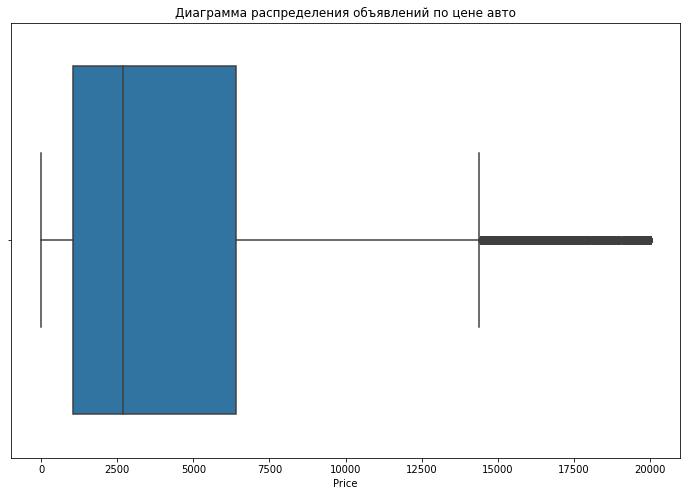

In [10]:
plt.figure(figsize=(12, 8))
plt.title("Диаграмма распределения объявлений по цене авто")
sns.boxplot(data['Price'])

Судя по "ящику с усами", минимум нормальных значений находится около 0, а максимум - чуть менее 15 000. Изучим эти минимумы и максимумы и определим, действительно ли они являются выбросами.

In [11]:
display(data[data['Price'] == 0].head())
data[data['Price'] == 0]['Price'].count()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,other,1990,other,0,corsa,150000,petrol,opel,other
111,0,other,2017,manual,0,golf,5000,petrol,volkswagen,other
115,0,small,1999,other,0,other,5000,petrol,volkswagen,other
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes


10772

Возможно бесплатно отдают битые или очень старые авто? 

In [12]:
print('Распределение авто с ценником 0 Евро (не-)находившихся в ремонте:')
data[data['Price'] == 0]['NotRepaired'].value_counts()

Распределение авто с ценником 0 Евро (не-)находившихся в ремонте:


other    5288
no       3479
yes      2005
Name: NotRepaired, dtype: int64

In [13]:
print('Распределение авто с ценником 0 Евро по году регистрации:')
data[data['Price'] == 0]['RegistrationYear'].value_counts().head(10)

Распределение авто с ценником 0 Евро по году регистрации:


2000    1418
1999     733
1998     721
1997     675
1995     654
2016     631
2005     585
2017     546
1996     471
2001     470
Name: RegistrationYear, dtype: int64

Однозначно определить, почему стоимость авто указано 0 Евро нельзя, так как с таким ценником встречаются как битые, так и не битые авто, старые и не очень. 

- **RegistrationYear** — год регистрации автомобиля

Определим диапазон "правдоподобности" данных, верхняя граница - дата скачивания анкет (2016 год), года регистрации из будущего быть не может, нижняя граница - дата начала серийного производства авто с ДВС 1885 год (согласно Википедии). Посмотрим на данные, которые не попадают в условный диапазон:

In [14]:
data[data['RegistrationYear'] < 1885]['RegistrationYear'].value_counts()

1000    37
1800     5
1500     5
1234     4
1111     3
1300     2
1600     2
1039     1
1688     1
1200     1
1602     1
1253     1
1255     1
1001     1
1400     1
Name: RegistrationYear, dtype: int64

In [15]:
data[data['RegistrationYear'] > 2016]['RegistrationYear'].value_counts()

2017    10441
2018     3959
9999       26
2019       25
5000       17
3000        7
6000        5
2500        4
7000        4
4000        3
9000        3
8000        2
5555        2
2222        2
2800        2
4500        2
5911        2
3700        1
3500        1
2900        1
8500        1
4100        1
9450        1
5900        1
6500        1
7100        1
5300        1
7800        1
8888        1
8200        1
9996        1
8455        1
2290        1
2066        1
5600        1
4800        1
3800        1
3200        1
9229        1
2200        1
7500        1
Name: RegistrationYear, dtype: int64

Очевидно, что это явные выбросы, появившиеся в результате ошибки либо некорректного заполнения объявления. Поскольку таких объявлений немного относительно всего датасета, избавимся от них удалением этих данных:

count    339773.000000
mean       2002.482222
std           7.091181
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64


<AxesSubplot:title={'center':'Диаграмма распределения объявлений по году регистрации авто'}, xlabel='RegistrationYear'>

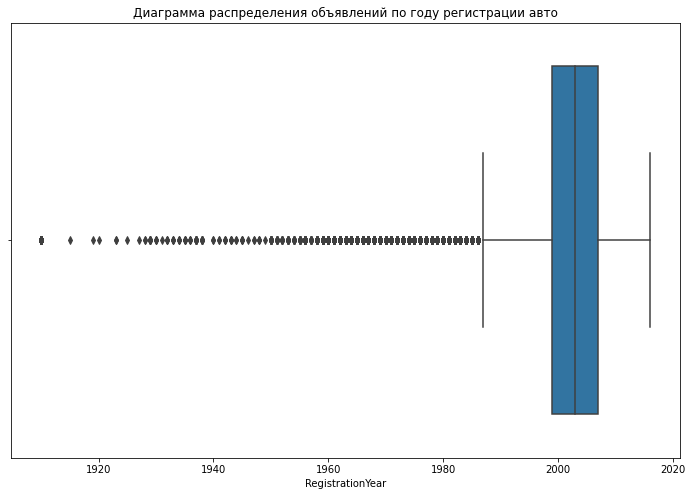

In [16]:
data = data.query("1885 <= RegistrationYear <= 2016")
print(data['RegistrationYear'].describe())
plt.figure(figsize=(12, 8))
plt.title("Диаграмма распределения объявлений по году регистрации авто")
sns.boxplot(data['RegistrationYear'])

In [17]:
import datetime as dt
data_new = pd.read_csv('/datasets/autos.csv')

data_new['DateCrawled'] = pd.to_datetime(data_new['DateCrawled'])
data_new['DateCrawled'] = data_new['DateCrawled'].dt.year
data_new['DateCrawled'].value_counts()

2016    354369
Name: DateCrawled, dtype: int64

Из диаграммы следует, что большинство авто по году регистрации находятся в диапазоне 1999 - 2008 годы, если от выбросов верхней границы мы избавились, то в данных еще встречаются объявления, год регистрации авто в которых значительно меньше наблюдаемого минимума, допустимо предположить, что это объявления о продаже ретроавтомобилей.
- **Power** — мощность (л. с.)

Здесь определить диапазон "правдоподобности" сложно, нет точного минимума и максимума показателя мощности двигателя при таком большом количестве данных. Явно, что значений 0 либо близких к нулю быть не может, как и слишком больших (более 1500 л.с.). Изучим минимумы и максимумы распределения значений:

In [18]:
data.groupby(['Power'])['Power'].count().head(10)

Power
0    36453
1       31
2       10
3        8
4       30
5      103
6       11
7       11
8        7
9        5
Name: Power, dtype: int64

In [19]:
data[data['Power'] > 1500]['Power'].count()

186

[]

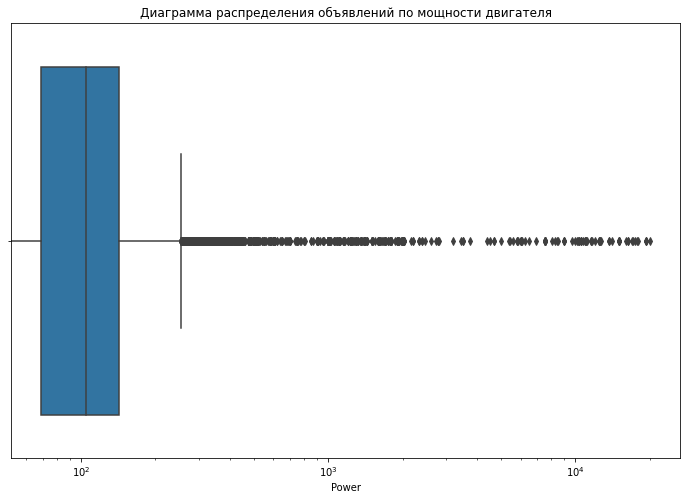

In [20]:
plt.figure(figsize=(12, 8))
plt.title("Диаграмма распределения объявлений по мощности двигателя")
sns.boxplot(data['Power']).semilogx()

Огромное количество объявлений имеют в графе "Мощность двигателя" значение 0, избавиться от всех этих объявлений мы не можем, их слишком много, замена на медианные или средние значения может исказить данные, поэтому оставим все как есть.

- **Kilometer** — пробег (км)

<AxesSubplot:title={'center':'гистограмма распределения объявлений по пробегу авто'}, xlabel='Kilometer', ylabel='Density'>

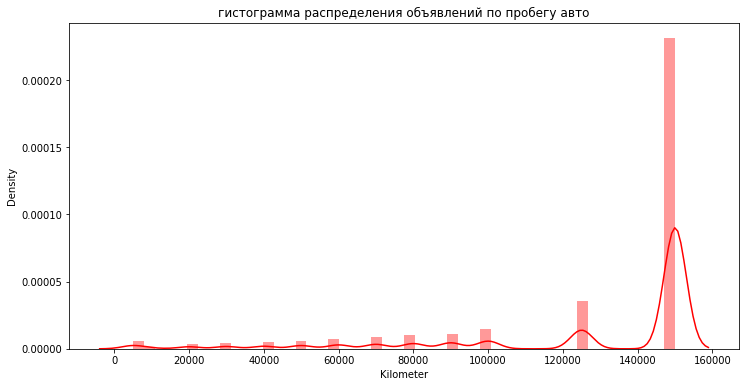

In [21]:
plt.figure(figsize=(12, 6))
plt.title("гистограмма распределения объявлений по пробегу авто")
sns.distplot(data['Kilometer'], color = 'r')

В данных о пробеге авто есть одна странность - максимальный указанный пробег 150 000 км (таких объявлений большинство), видимо максимум вводимого значения был ограничен на таком уровне. Оставим все как есть, тем более что как-то качественно исправить это мы вряд ли способны.

#### Проверим данные на наличие явных дубликатов:

In [22]:
data.duplicated().sum()

44244

Дубликатов достаточно много, удалим их из данных, чтобы не допустить переобучения модели:

In [23]:
data = data.drop_duplicates().reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295529 entries, 0 to 295528
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             295529 non-null  int64 
 1   VehicleType       295529 non-null  object
 2   RegistrationYear  295529 non-null  int64 
 3   Gearbox           295529 non-null  object
 4   Power             295529 non-null  int64 
 5   Model             295529 non-null  object
 6   Kilometer         295529 non-null  int64 
 7   FuelType          295529 non-null  object
 8   Brand             295529 non-null  object
 9   NotRepaired       295529 non-null  object
dtypes: int64(4), object(6)
memory usage: 22.5+ MB


### Проверим данные на мультиколлинеарность

<AxesSubplot:>

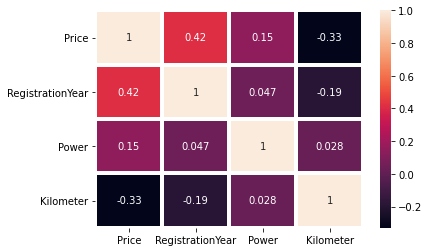

In [24]:
sns.heatmap(data.corr(), annot=True, linewidths=3, linecolor='white')

Зависимость целевого признака (Price) от других признаков есть, но незначительная. Нет и явной зависимости обучающих признаков между собой, поэтому удаление какого-либо из признаков не требуется.

### Подготовка признаков к обучению модели

#### Кодирование признаков

Для линейных моделей применима техника кодирования OHE, для деревянных моделей - техника OE, для бустинговых моделей кодирование признаков не требуется, но рекомендуется перевести все нечисловые типы данных в тип **category**. Создадим три датасета с разными техниками кодирования (OHE, OE, CAT), которые в дальнейшем будем использовать для обучения моделей:

In [25]:
columns_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

# кодирование техникой OHE
data_ohe = pd.get_dummies(data, drop_first=True, columns = columns_features)

# кодирование техникой OE
encoder = OrdinalEncoder()
data_oe = data.copy()
data_oe[columns_features] = encoder.fit_transform(data_oe[columns_features])

# без кодирования с типами данных category
data_cat = data.copy()
def obj_to_cat (data_cat):
    for c in data_cat.columns:
        col_type = data_cat[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            data_cat[c] = data_cat[c].astype('category')
            
for features in ['features_train_without', 'features_test_without']:
    obj_to_cat(data_cat)

#### Деление на выборки

Разделим каждый из полученных датасетов на 3 выборки тренировочную, валидационную и тестовую в отношении 60/20/20, напишем собственную функцию, которая будет отделять признаки и целевой признак, а также делить данные на две выборки в указанной пропорции:

In [26]:
def split_func (data):
    target = data['Price']
    features = data.drop('Price', axis=1)
    
    features_train, features_valid_test, target_train, target_valid_test = train_test_split(
        features, target, test_size=0.4, random_state=12345)
    features_valid, features_test, target_valid, target_test = train_test_split(
        features_valid_test, target_valid_test, test_size=0.5, random_state=12345)
    
    
    return features_train, features_valid, features_test, target_train, target_valid, target_test

Разделим каждый из полученных датасетов и посмотрим на получившиеся размеры выборок:

In [27]:
features_train_ohe, features_valid_ohe, features_test_ohe, target_train_ohe, target_valid_ohe, target_test_ohe = split_func(data_ohe)
for features in [features_train_ohe, features_valid_ohe, features_test_ohe, target_train_ohe, target_valid_ohe, target_test_ohe]:
    print(features.shape)

(177317, 308)
(59106, 308)
(59106, 308)
(177317,)
(59106,)
(59106,)


In [29]:
features_train_oe, features_valid_oe, features_test_oe, target_train_oe, target_valid_oe, target_test_oe = split_func(data_oe)
for features in [features_train_oe, features_valid_oe, features_test_oe, target_train_oe, target_valid_oe, target_test_oe]:
    print(features.shape)

(177317, 9)
(59106, 9)
(59106, 9)
(177317,)
(59106,)
(59106,)


In [30]:
features_train_cat, features_valid_cat, features_test_cat, target_train_cat, target_valid_cat, target_test_cat = split_func(data_cat)
for features in [features_train_cat, features_valid_cat, features_test_cat, target_train_cat, target_valid_cat, target_test_cat]:
    print(features.shape)

(177317, 9)
(59106, 9)
(59106, 9)
(177317,)
(59106,)
(59106,)


#### Масштабирование признаков

Проведем масштабирование признаков во всех выборках, напишем для этого собственную функцию:

In [31]:
def scal_func (features_train, features_valid, features_test):
    numeric = ['RegistrationYear', 'Power', 'Kilometer']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    
    return features_train, features_valid, features_test

Масштабируем признаки каждого из датасетов:

In [32]:
features_train_ohe, features_valid_ohe, features_test_ohe = scal_func (features_train_ohe, features_valid_ohe, features_test_ohe)
features_train_oe, features_valid_oe, features_test_oe = scal_func (features_train_oe, features_valid_oe, features_test_oe)
features_train_cat, features_valid_cat, features_test_cat = scal_func (features_train_cat, features_valid_cat, features_test_cat)

**ВЫВОД**:

- На этапе предобработки данных избавились от лишних признаков, которые не повлияют на качество модели
- Пропущенные значения в категориальных переменных заменили значением "other"
- Пропущенные и нулевые значения в количественных переменных оставили без изменений (качественно их заменить нельзя)
- Избавились от явных выбросов в столбце "Год регистрации" авто
- Избавились от явных дубликатов в данных
- Для обучения раного типа моделей создали три сета с данными, для каждого из которых применили отдельный вид кодирования
- Провели масштабирование данных всех трех фреймов

Предобработка данных завершена, можно приступить к обучению моделей.

## Обучение моделей

Создадим словарь, куда будем записывать данные о скорости и качестве работы моделей:

In [33]:
test_results = {}

На тренировочной выборке поочередно проведем обучение следующих моделей: линейная регрессия, решающее дерево, случайный лес, CatBoost, LightGBM.

### Линейная регрессия (LinearRegression)

- Скорость обучения:

In [34]:
%%time
linear_model = LinearRegression()
linear_model.fit(features_train_ohe, target_train_ohe)

CPU times: user 15.5 s, sys: 8.44 s, total: 23.9 s
Wall time: 23.9 s


LinearRegression()

- Скорость предсказания

In [35]:
%%time
# предсказание на валидационной выборке
predictions_valid_linear_model = linear_model.predict(features_valid_ohe)
# предсказание на тестовой выборке
predictions_test_linear_model = linear_model.predict(features_test_ohe)

CPU times: user 220 ms, sys: 182 ms, total: 403 ms
Wall time: 392 ms


- Качество предсказания

In [36]:
rmse_valid_linear_model = mean_squared_error(target_valid_ohe, predictions_valid_linear_model, squared= False)
print(f"RMSE для линейной модели на валидационной выборке: {rmse_valid_linear_model:.2f}")
rmse_test_linear_model = mean_squared_error(target_test_ohe, predictions_test_linear_model, squared= False)
print(f"RMSE для линейной модели на тестовой выборке: {rmse_test_linear_model:.2f}")

RMSE для линейной модели на валидационной выборке: 2962.41
RMSE для линейной модели на тестовой выборке: 2978.39


In [37]:
test_results['LinearRegression'] = ['18.5', '0.308', round(rmse_test_linear_model, 2)]

### Решающее дерево (DecisionTreeRegressor)

Определим оптимальное значение глубины дерева max_depth, за метрику качества модели примем показатель RMSE на валидационной выборке:

In [46]:
best_depht_dtr = 0
best_rmse_dtr = 10000
for depth in np.arange(8, 18):
    dtr_model = DecisionTreeRegressor(max_depth=depth, random_state=12345) 
    dtr_model.fit(features_train_oe, target_train_oe)
    
    print("Для max_depth =", depth, ":")
    predictions_valid_dtr_model = dtr_model.predict(features_valid_oe)
    rmse_valid_dtr_model = mean_squared_error(target_valid_oe, predictions_valid_dtr_model, squared= False)
    print(f"RMSE на валидационной выборке: {rmse_valid_dtr_model:.2f}")
    print()
    
    if rmse_valid_dtr_model < best_rmse_dtr:
        best_depth_dtr = depth
        best_rmse_dtr = rmse_valid_dtr_model     

print("Окончательный результат:")
print(f"Лучший показатель RMSE ~ {best_rmse_dtr:.2f} при гиперпараметре max_depth = {best_depth_dtr}")

Для max_depth = 8 :
RMSE на валидационной выборке: 2235.29

Для max_depth = 9 :
RMSE на валидационной выборке: 2172.67

Для max_depth = 10 :
RMSE на валидационной выборке: 2125.98

Для max_depth = 11 :
RMSE на валидационной выборке: 2093.33

Для max_depth = 12 :
RMSE на валидационной выборке: 2087.27

Для max_depth = 13 :
RMSE на валидационной выборке: 2100.09

Для max_depth = 14 :
RMSE на валидационной выборке: 2105.69

Для max_depth = 15 :
RMSE на валидационной выборке: 2128.05

Для max_depth = 16 :
RMSE на валидационной выборке: 2149.01

Для max_depth = 17 :
RMSE на валидационной выборке: 2183.41

Окончательный результат:
Лучший показатель RMSE ~ 2087.27 при гиперпараметре max_depth = 12


Оптимальное значение гиперпараметра max_depth для модели DecisionTreeRegressor стоит принять 12, с увеличением этого параметра модель переобучается и показатель RMSE становится хуже. Определим скорость обучения модели при max_depth = 12, а также скорость и качество предсказания на тестовой выборке:

- Скорость обучения:

In [49]:
%%time
dtr_model = DecisionTreeRegressor(max_depth=best_depth_dtr, random_state=12345) 
dtr_model.fit(features_train_oe, target_train_oe)

CPU times: user 457 ms, sys: 0 ns, total: 457 ms
Wall time: 456 ms


DecisionTreeRegressor(max_depth=12, random_state=12345)

- Скорость предсказания

In [50]:
%%time
predictions_test_dtr_model = dtr_model.predict(features_test_oe)

CPU times: user 11.5 ms, sys: 0 ns, total: 11.5 ms
Wall time: 10.2 ms


- Качество предсказания

In [42]:
rmse_test_dtr_model = mean_squared_error(target_test_oe, predictions_test_dtr_model, squared= False)
print(f"RMSE для модели решающего дерева на тестовой выборке: {rmse_test_dtr_model:.2f}")

RMSE для модели решающего дерева на тестовой выборке: 2124.87


In [43]:
test_results['DecisionTreeRegressor'] = ['0.64', '0.01618', round(rmse_test_dtr_model, 2)]

### Случайный лес (RandomForestRegressor)

In [51]:
best_depht_rf = 0
best_est_rf = 0
best_rmse_rf = 10000
for depth in np.arange(15, 17):
    for est in np.arange(43, 48):
        rf_model = RandomForestRegressor(max_depth = depth,
                                         n_estimators = est,
                                         random_state=12345)
        rf_model.fit(features_train_oe, target_train_oe)
        
        print("Для гиперпараметров max_depth = ", depth, " и n_estimators = ", est, ":")
        predictions_valid_rf_model = rf_model.predict(features_valid_oe)
        rmse_valid_rf_model = mean_squared_error(target_valid_oe, predictions_valid_rf_model, squared= False)
        print(f"RMSE на валидационной выборке: {rmse_valid_rf_model:.2f}")    
        print()
        if rmse_valid_rf_model < best_rmse_rf:
            best_depth_rf = depth
            best_est_rf = est
            best_rmse_rf = rmse_valid_rf_model  

print("Окончательный результат:")
print(f"Лучший показатель RMSE ~ {best_rmse_rf:.2f} при гиперпараметрах max_depth = {best_depth_rf} и n_estimators = {best_est_rf}")        

Для гиперпараметров max_depth =  15  и n_estimators =  43 :
RMSE на валидационной выборке: 1840.46
Для гиперпараметров max_depth =  15  и n_estimators =  44 :
RMSE на валидационной выборке: 1840.03
Для гиперпараметров max_depth =  15  и n_estimators =  45 :
RMSE на валидационной выборке: 1840.04
Для гиперпараметров max_depth =  15  и n_estimators =  46 :
RMSE на валидационной выборке: 1839.91
Для гиперпараметров max_depth =  15  и n_estimators =  47 :
RMSE на валидационной выборке: 1840.00
Для гиперпараметров max_depth =  16  и n_estimators =  43 :
RMSE на валидационной выборке: 1831.43
Для гиперпараметров max_depth =  16  и n_estimators =  44 :
RMSE на валидационной выборке: 1830.89
Для гиперпараметров max_depth =  16  и n_estimators =  45 :
RMSE на валидационной выборке: 1831.14
Для гиперпараметров max_depth =  16  и n_estimators =  46 :
RMSE на валидационной выборке: 1831.13
Для гиперпараметров max_depth =  16  и n_estimators =  47 :
RMSE на валидационной выборке: 1831.22
Окончатель

Оптимальное значение гиперпараметров max_depth и n_estimators для модели DecisionTreeRegressor стоит принять 16 и 44 соответственно. Определим скорость обучения модели при указанных значениях, а также скорость и качество предсказания на тестовой выборке:

- Скорость обучения:

In [52]:
%%time
rf_model = RandomForestRegressor(max_depth = best_depth_rf, n_estimators = best_est_rf, random_state=12345)
rf_model.fit(features_train_oe, target_train_oe)

CPU times: user 17.5 s, sys: 0 ns, total: 17.5 s
Wall time: 17.8 s


RandomForestRegressor(max_depth=16, n_estimators=44, random_state=12345)

- Скорость предсказания

In [53]:
%%time
predictions_test_rf_model = rf_model.predict(features_test_oe)

CPU times: user 596 ms, sys: 0 ns, total: 596 ms
Wall time: 603 ms


- Качество предсказания

In [54]:
rmse_test_rf_model = mean_squared_error(target_test_oe, predictions_test_rf_model, squared= False)
print(f"RMSE для модели случайного леса на тестовой выборке: {rmse_test_rf_model:.2f}")

RMSE для модели случайного леса на тестовой выборке: 1849.10


In [55]:
test_results['RandomForestRegressor'] = ['130', '0,614', round(rmse_test_rf_model, 2)]

### Регрессия CatBoost

Перед началом обучения бустинговых моделей определим список всех категориальных переменных в тренировочной выборке:

In [36]:
numerical_features = ['RegistrationYear', 'Power', 'Kilometer']

categorical_features = [col for col in list(features_train_cat.columns) if col not in numerical_features]

- Скорость обучения

In [104]:
%%time
cat_model = CatBoostRegressor(learning_rate=0.1, random_state=12345, verbose=50) 
cat_model.fit(features_train_cat, target_train_cat, cat_features=categorical_features)

0:	learn: 4326.2269450	total: 25.5ms	remaining: 25.5s
50:	learn: 2061.0929599	total: 1.26s	remaining: 23.5s
100:	learn: 1940.9244553	total: 2.47s	remaining: 22s
150:	learn: 1883.8810817	total: 3.64s	remaining: 20.5s
200:	learn: 1847.3787222	total: 4.82s	remaining: 19.1s
250:	learn: 1821.7242321	total: 5.96s	remaining: 17.8s
300:	learn: 1802.1933964	total: 7.14s	remaining: 16.6s
350:	learn: 1785.0249629	total: 8.28s	remaining: 15.3s
400:	learn: 1770.7886145	total: 9.43s	remaining: 14.1s
450:	learn: 1758.3289808	total: 10.6s	remaining: 12.9s
500:	learn: 1747.8005826	total: 11.7s	remaining: 11.7s
550:	learn: 1737.5880488	total: 12.9s	remaining: 10.5s
600:	learn: 1728.4127048	total: 14.1s	remaining: 9.33s
650:	learn: 1719.9865066	total: 15.2s	remaining: 8.15s
700:	learn: 1712.0871379	total: 16.4s	remaining: 6.97s
750:	learn: 1704.3489321	total: 17.5s	remaining: 5.81s
800:	learn: 1697.2041611	total: 18.6s	remaining: 4.63s
850:	learn: 1690.4436891	total: 19.8s	remaining: 3.46s
900:	learn: 16

- Скорость предсказания

In [105]:
%%time
cat_valid_predictions = cat_model.predict(features_valid_cat)
cat_test_predictions = cat_model.predict(features_test_cat)

CPU times: user 6.3 s, sys: 15.9 ms, total: 6.31 s
Wall time: 6.31 s


- Качество предсказания

In [106]:
rmse_valid_cat_model = mean_squared_error(target_valid_cat, cat_valid_predictions, squared= False)
print(f"RMSE для модели CatBoost на валидационной выборке: {rmse_cat_model:.2f}")
rmse_test_cat_model = mean_squared_error(target_test_cat, cat_test_predictions, squared= False)
print(f"RMSE для модели CatBoost на тестовой выборке: {rmse_test_cat_model:.2f}")

RMSE для модели CatBoost на валидационной выборке: 1760.60
RMSE для модели CatBoost на тестовой выборке: 1771.74


In [107]:
test_results['CatBoostRegressor'] = ['126', '1.38', round(rmse_cat_model, 2)]

### Регрессия LGBM

In [37]:
categorical_features

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

- Скорость обучения

In [39]:
%%time

lgbm_model = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=100, 
                      random_state=12345,
                      categorical_feature=categorical_features)
lgbm_model.fit(features_train_cat, target_train_cat)

CPU times: user 18min 17s, sys: 5.59 s, total: 18min 23s
Wall time: 18min 29s


LGBMRegressor(categorical_feature=['VehicleType', 'Gearbox', 'Model',
                                   'FuelType', 'Brand', 'NotRepaired'],
              num_leaves=100, random_state=12345)

- Скорость предсказания

In [110]:
%%time
lgbm_valid_predictions = lgbm_model.predict(features_valid_cat)
lgbm_test_predictions = lgbm_model.predict(features_test_cat)

CPU times: user 1.88 s, sys: 151 ms, total: 2.03 s
Wall time: 2.09 s


- Качество предсказания

In [111]:
rmse_valid_lgbm_model = mean_squared_error(target_valid_cat, lgbm_valid_predictions, squared= False)
print(f"RMSE для модели LightGBM на валидационной выборке: {rmse_cat_model:.2f}")
rmse_test_lgbm_model = mean_squared_error(target_test_cat, lgbm_test_predictions, squared= False)
print(f"RMSE для модели LightGBM на тестовой выборке: {rmse_test_cat_model:.2f}")

RMSE для модели LightGBM на валидационной выборке: 1760.60
RMSE для модели LightGBM на тестовой выборке: 1771.74


In [112]:
test_results['LGBMRegressor'] = ['22.6', '2.01', round(rmse_test_lgbm_model, 2)]

## Анализ моделей

In [113]:
test_results = pd.DataFrame.from_dict(test_results,
                                      orient = 'index',
                                      columns = ['Speed_train, s', 'Speed_predict, s', 'RMSE'])
test_results

,"Speed_train, s","Speed_predict, s",RMSE
LinearRegression,18.5,0.308,2978.39
DecisionTreeRegressor,0.64,0.01618,2107.67
RandomForestRegressor,130,"0,614",1876.47
CatBoostRegressor,126,1.38,1760.60
LGBMRegressor,22.6,2.01,1771.44


**Вывод**

- Оценивая качество моделей по метрике RMSE можно отметить, что простая модель случайного леса показала результат, сравнимый с бустинговыми моделями CatBoost и LGBM~
- Время, затраченное на обучение модели случайного леса с учетом подбора гиперпараметров, значительно больше, чем у бустинговых моделей
- Сравнивая бустинговые модели между собой, можно сказать, что качество прогонозирования у обеих моделей примерно одного уровня, но время на обучения модель LGBM тратит значительно меньше, чем CatBoost
- Исходя из вышенаписанного в нашем случае по показателю время/качество можно делать выбор в пользу LGBM модели